In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from csv_parser import CSVParser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as ts
import os

2024-10-09 13:08:53.979056: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 13:08:53.989439: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 13:08:54.072137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 13:08:54.149603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 13:08:54.228919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
parser = CSVParser(folderpath="../../Project materials(1)/")
df = parser.retrieve_training_data()
df.head()

#Column 6 is lat.
#Column 7 is long.


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,etaParsed
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,2024-01-09 23:00:00
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,2024-12-29 20:00:00
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,2024-01-02 09:00:00
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,2024-12-31 20:00:00
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,2024-01-25 12:00:00


In [4]:
#Using tokenizer on vesselId and portId
tokenizer = Tokenizer()

#Ensuring that all missing values are empty strings
df["vesselId"] = df["vesselId"].fillna("")
df["portId"] = df["portId"].fillna("")

# Fit the tokenizer on both columns separately
tokenizer.fit_on_texts(df["vesselId"])
tokenizer.fit_on_texts(df["portId"])

# Convert the text columns to sequences of integers
seq_vessel = tokenizer.texts_to_sequences(df["vesselId"])
seq_port = tokenizer.texts_to_sequences(df["portId"])

# Pad the sequences to ensure uniform length (for each column separately)
max_length_vessel = max(len(seq) for seq in seq_vessel)
max_length_port = max(len(seq) for seq in seq_port)

pad_seq_vessel = pad_sequences(seq_vessel, maxlen=max_length_vessel, padding='post')
pad_seq_port = pad_sequences(seq_port, maxlen=max_length_port, padding='post')

pad_seq_vessel = np.array(pad_seq_vessel).astype(np.float32)
pad_seq_port = np.array(pad_seq_port).astype(np.float32)

# Add these sequences back to the DataFrame (or keep them as arrays for model input)
df['padded_vesselId'] = pad_seq_vessel
df['padded_portId'] = pad_seq_port

#Converting time stamps to seconds.
df["time_s"] = df['time'].astype(int)//1e9

df["eta_s"] = df['etaParsed'].astype(int)//1e9

#Getting rid of columns time and etaParsed.
df = df[["time_s", "cog", "sog", "rot", "heading", "navstat","latitude","longitude","vesselId","padded_vesselId", "padded_portId", "eta_s"]].copy()
df.head()



,time_s,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,padded_vesselId,padded_portId,eta_s
0,1.704067e+09,284.0,0.7,0,88,0,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,595.0,966.0,1.704841e+09
1,1.704067e+09,109.6,0.0,-6,347,1,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,535.0,172.0,1.735502e+09
2,1.704067e+09,111.0,11.0,0,112,0,39.19065,-76.47567,61e9f436b937134a3c4c0131,482.0,7.0,1.704186e+09
3,1.704067e+09,96.4,0.0,0,142,1,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,686.0,197.0,1.735675e+09
4,1.704067e+09,214.0,19.7,0,215,0,35.88379,-5.91636,61e9f41bb937134a3c4c0087,738.0,534.0,1.706184e+09


In [5]:
def sequencing(df, window_size):
  ids = df.vesselId.unique()
  X = []
  y = []
  for j in range(len(ids)):
    df_id = df[df["vesselId"] == ids[j]].copy()
    if df_id.shape[0]>window_size:
      df_id_np = df_id.to_numpy()
      for i in range(len(df_id_np)-window_size):
        row = [r for r in df_id_np[i:i+window_size]]
        X.append(row)
        label = [df_id_np[i+window_size][6], df_id_np[i+window_size][7]]
        y.append(label)
  
  y = np.array(y)
  X = np.array(X)
  y_reshaped = y[:,:, np.newaxis]
  XandY=np.concatenate((X, np.tile(y_reshaped, (1, 1, X.shape[2]))), axis=1)
  XandY[XandY[:,0,0].argsort()]
  X = XandY[:,:-2,:]
  y = XandY[:,-2:,0]
  
  return X,y

Xs,ys = sequencing(df, 7)


In [6]:


Xs = np.delete(Xs, 8, axis=2)


In [7]:
print(Xs.shape)
train_X = Xs[:int(np.round(Xs.shape[0]*0.7))]
train_Y = ys[:int(np.round(Xs.shape[0]*0.7))]
val_X = Xs[int(np.round(Xs.shape[0]*0.7)):int(np.round(Xs.shape[0]*0.85))]
val_Y = ys[int(np.round(Xs.shape[0]*0.7)):int(np.round(Xs.shape[0]*0.85))]
test_X = Xs[int(np.round(Xs.shape[0]*0.85)):]
test_Y = ys[int(np.round(Xs.shape[0]*0.85)):]

(1517255, 7, 11)


In [8]:
print(Xs[0,:,:])
def preprocess_design(X, lo_mean, lo_std, la_mean, la_std ):
  X[:, :, 6] = (X[:, :, 6] - la_mean) / la_std
  X[:, :, 7] = (X[:, :, 7] - lo_mean) / lo_std
  X[:, :, 3] = X[:, :, 3].astype(np.float32)
  X[:, :, 4] = X[:, :, 4].astype(np.float32)
  X[:, :, 5] = X[:, :, 5].astype(np.float32)

  return X

def preprocess_output(y,lo_mean, lo_std, la_mean, la_std):
  y[:, 0] = (y[:, 0] - la_mean) / la_std
  y[:, 1] = (y[:, 1] - lo_mean) / lo_std

  return y

[[1704067225.0 284.0 0.7 0 88 0 -34.7437 -57.8513 595.0 966.0
  1704841200.0]
 [1704089348.0 92.8 14.2 0 90 0 -35.16787 -56.7721 595.0 966.0
  1704841200.0]
 [1704091099.0 90.5 14.3 0 88 0 -35.16863 -56.63185 595.0 966.0
  1704841200.0]
 [1704092335.0 88.2 14.3 0 86 0 -35.16805 -56.5319 595.0 966.0
  1704841200.0]
 [1704093356.0 88.3 12.3 0 86 0 -35.16715 -56.45306 595.0 966.0
  1704841200.0]
 [1704094095.0 86.8 11.7 0 85 0 -35.16646 -56.40306 595.0 966.0
  1704841200.0]
 [1704096215.0 70.4 15.2 0 67 0 -35.16544 -56.23866 595.0 966.0
  1704841200.0]]


In [9]:
lang_t_mean = np.mean(train_X[:, :, 6])
lang_t_std = np.std(train_X[:, :, 6])

long_t_mean = np.mean(train_X[:, :, 7])
long_t_std = np.std(train_X[:, :, 7])

train_X = preprocess_design(train_X, long_t_mean, long_t_std, lang_t_mean, lang_t_std)
train_Y = preprocess_output(train_Y, long_t_mean, long_t_std, lang_t_mean, lang_t_std)
val_X = preprocess_design(val_X, long_t_mean, long_t_std, lang_t_mean, lang_t_std)
val_Y = preprocess_output(val_Y, long_t_mean, long_t_std, lang_t_mean, lang_t_std)
test_X = preprocess_design(test_X, long_t_mean, long_t_std, lang_t_mean, lang_t_std)
test_Y = preprocess_output(test_Y, long_t_mean, long_t_std, lang_t_mean, lang_t_std)

In [16]:
print(train_X[1, :, :])

[[1704089348.0 92.8 14.2 0 90 0 -3.633415549939463 -1.1625419351294957
  595.0 966.0 1704841200.0]
 [1704091099.0 90.5 14.3 0 88 0 -3.6334523143478274 -1.16008197308319
  595.0 966.0 1704841200.0]
 [1704092335.0 88.2 14.3 0 86 0 -3.633424257299339 -1.1583288664412772
  595.0 966.0 1704841200.0]
 [1704093356.0 88.3 12.3 0 86 0 -3.63338072049996 -1.156946025744445
  595.0 966.0 1704841200.0]
 [1704094095.0 86.8 11.7 0 85 0 -3.633347342287103 -1.1560690339275803
  595.0 966.0 1704841200.0]
 [1704096215.0 70.4 15.2 0 67 0 -3.6332980005811395 -1.1531854848337288
  595.0 966.0 1704841200.0]
 [1704106179.0 91.1 15.0 0 91 0 -3.629612852384815 -1.1403112449621544
  595.0 966.0 1704841200.0]]


In [27]:
train_X= np.array(train_X, dtype = np.float32)
val_X = np.array(val_X, dtype = np.float32)
test_X = np.array(test_X, dtype = np.float32)
test_Y = np.array(test_Y, dtype = np.float32)
val_Y = np.array(val_Y, dtype = np.float32)
train_Y = np.array(train_Y, dtype = np.float32)



train_X = ts.convert_to_tensor(train_X, dtype = np.float32)
val_X = ts.convert_to_tensor(val_X, dtype = np.float32)
test_X = ts.convert_to_tensor(test_X, dtype = np.float32)




In [31]:


model1 = Sequential()
model1.add(LSTM(64, input_shape = (7,11)))
model1.add(Dense(8, 'relu'))
model1.add(Dense(2, 'linear'))

model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,994 (78.10 KB)

 Trainable params: 19,994 (78.10 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [34]:
model1.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=10, callbacks=[cp5])
#Epoch must be tuned. 

Epoch 1/10
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 1.0002 - root_mean_squared_error: 1.0001 - val_loss: 2.1163 - val_root_mean_squared_error: 1.4547
Epoch 2/10
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 1.0018 - root_mean_squared_error: 1.0009 - val_loss: 2.1205 - val_root_mean_squared_error: 1.4562
Epoch 3/10
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 0.9989 - root_mean_squared_error: 0.9995 - val_loss: 2.1190 - val_root_mean_squared_error: 1.4557
Epoch 4/10
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.9998 - root_mean_squared_error: 0.9999 - val_loss: 2.1158 - val_root_mean_squared_error: 1.4546
Epoch 5/10
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 1.0013 - root_mean_squared_error: 1.0007 - val_loss: 2.1181 - val_root_mean_squared_error: 1.4554
Epoch 6/10
33190/33190 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 1.0001 - root_mean_squared_error: 1.0000 - val_loss: 2.1134 - val_root_mean_squared_error: 1.4538
Epoch 7/10
33190/33190

7113/7113 ━━━━━━━━━━━━━━━━━━━━ 5s 721us/step


,Latitude Predictions,Latitude Actuals,Longitude Predictions,Longitude Actuals
0,0.015678,0.550195,0.01209,-0.110199
1,0.015678,0.550195,0.01209,-0.110198
2,0.015678,0.550194,0.01209,-0.110198
3,0.015678,0.550194,0.01209,-0.110198
4,0.015678,0.550194,0.01209,-0.110198
...,...,...,...,...
95,0.015678,0.817224,0.01209,-0.058363
96,0.015678,0.819397,0.01209,-0.056684
97,0.015678,0.820969,0.01209,-0.054724
98,0.015678,0.822206,0.01209,-0.052989


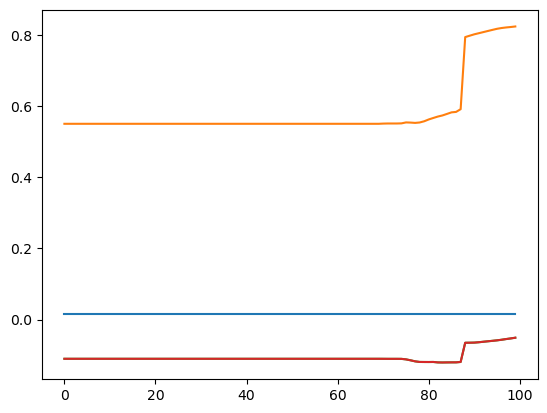

In [35]:
#Model predictions
def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  lat_preds, long_preds = predictions[:, 0], predictions[:, 1]
  lat_actuals, long_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Latitude Predictions': lat_preds,
                          'Latitude Actuals':lat_actuals,
                          'Longitude Predictions': long_preds,
                          'Longitude Actuals': long_actuals
                          })
  plt.plot(df['Latitude Predictions'][start:end])
  plt.plot(df['Latitude Actuals'][start:end])
  plt.plot(df['Longitude Actuals'][start:end])
  plt.plot(df['Longitude Actuals'][start:end])
  return df[start:end]

plot_predictions(model1, test_X, test_Y, start = 0, end = 100)